<a href="https://colab.research.google.com/github/fatimakgeneng/LangChain-RAG-Project/blob/main/LangChain_RAG_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Using Pinecone**

In [22]:
%pip install -q -U python-dotenv langchain pinecone-client google-generativeai openai tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 5.9 MB/s eta 0:00:00


In [23]:
import os
from dotenv import load_dotenv
from google.colab import userdata

# Retrieve and set the environment variables
os.environ['PINECONE_API_KEY'] = userdata.get('PINECONE_API_KEY')
os.environ['PINECONE_ENVIRONMENT'] = userdata.get('PINECONE_ENVIRONMENT')
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

In [24]:
from pinecone import Pinecone
pc = Pinecone(api_key=os.environ['PINECONE_API_KEY'], environment=os.environ['PINECONE_ENVIRONMENT'])

In [25]:
# Connect to an existing index
index_name = "gemini-rag-index"  # Replace with your actual index name
index = pc.Index(index_name)
print(f"Successfully connected to index: {index_name}")

Successfully connected to index: gemini-rag-index


In [26]:
%pip install -q -U langchain-google-genai
from langchain_google_genai.embeddings import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",
    google_api_key=os.environ["GOOGLE_API_KEY"])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 2.4 MB/s eta 0:00:00


In [27]:
%pip install -q -U langchain-community
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Load documents
loader = TextLoader("/content/document.txt")  # Replace with your file
documents = loader.load()

# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
docs = text_splitter.split_documents(documents)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.2 MB/s eta 0:00:00


In [28]:
from tqdm import tqdm

# Create embeddings and upload to Pinecone
for doc in tqdm(docs):
    vector = embeddings.embed_query(doc.page_content)
    # Pass metadata as a dictionary
    index.upsert([(doc.metadata["source"], vector, {"text": doc.page_content})])

100%|██████████| 7/7 [00:01<00:00,  3.85it/s]


In [29]:
from langchain.vectorstores import Pinecone

retriever = Pinecone.from_existing_index(index_name=index_name, embedding=embeddings, text_key="text")

In [30]:
%pip install -q -U langchain-google-genai
from langchain_google_genai import ChatGoogleGenerativeAI

gemini_model = ChatGoogleGenerativeAI(api_key=os.environ.get("GOOGLE_API_KEY"),model="gemini-1.5-flash", temperature=0.7)

In [31]:
from langchain.chains import RetrievalQA
from langchain.vectorstores.base import VectorStoreRetriever

# Create a VectorStoreRetriever from your Pinecone index
retriever = VectorStoreRetriever(vectorstore=Pinecone.from_existing_index(index_name=index_name, embedding=embeddings, text_key="text"))


qa_chain = RetrievalQA.from_chain_type(
    llm=gemini_model,
    chain_type="stuff",  # Other options: "map_reduce", "refine"
    retriever=retriever)

In [33]:
query = "what happens when you integrate the AI in genetics"
response = qa_chain.run(query)
print(f"Fatima's Question: {query}")
print()
print(f"LLM's Response: {response}")

Fatima's Question: what happens when you integrate the AI in genetics

LLM's Response: Integrating AI into genetics has the potential to improve human health and solve critical challenges.  However, responsible innovation, collaboration, and regulation are crucial for its success.


# **Few important commands** such as list of models, dimentions & functions of pinecone

In [ ]:
import google.generativeai as genai

list(genai.list_models())   # models to choose from

[Model(name='models/chat-bison-001',
       base_model_id='',
       version='001',
       display_name='PaLM 2 Chat (Legacy)',
       description='A legacy text-only model optimized for chat conversations',
       input_token_limit=4096,
       output_token_limit=1024,
       supported_generation_methods=['generateMessage', 'countMessageTokens'],
       temperature=0.25,
       max_temperature=None,
       top_p=0.95,
       top_k=40),
 Model(name='models/text-bison-001',
       base_model_id='',
       version='001',
       display_name='PaLM 2 (Legacy)',
       description='A legacy model that understands text and generates text as an output',
       input_token_limit=8196,
       output_token_limit=1024,
       supported_generation_methods=['generateText', 'countTextTokens', 'createTunedTextModel'],
       temperature=0.7,
       max_temperature=None,
       top_p=0.95,
       top_k=40),
 Model(name='models/embedding-gecko-001',
       base_model_id='',
       version='001',
      

In [ ]:
list(dir(retriever))  #List of functions in pinecone

['InputType',
 'OutputType',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__class_vars__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__fields__',
 '__fields_set__',
 '__format__',
 '__ge__',
 '__get_pydantic_core_schema__',
 '__get_pydantic_json_schema__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__orig_bases__',
 '__parameters__',
 '__pretty__',
 '__private_attributes__',
 '__pydantic_complete__',
 '__pydantic_computed_fields__',
 '__pydantic_core_schema__',
 '__pydantic_custom_init__',
 '__pydantic_decorators__',
 '__pydantic_extra__',
 '__pydantic_fields__',
 '__pydantic_fields_set__',
 '__pydantic_generic_metadata__',
 '__pydantic_init_subclass__',
 '__pydantic_parent_namespace__',
 '__pydantic_post_init__',
 '__pydantic_private__',
 '__

In [ ]:
len(vector)   # dimensions

768

# **Face detection using FaceNet & Milvus database**

In [1]:
!pip install -Uq facenet-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.

In [2]:
!pip install -Uq Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 28.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 11.1.0 which is incompatible.


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

import torchvision.transforms as transforms
from PIL import Image

In [4]:
from facenet_pytorch import MTCNN, InceptionResnetV1

model = InceptionResnetV1(pretrained='vggface2').eval()
# model   Optional (If wanna check the model details)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [5]:
# Preprocessing function to transform the image into a tensor
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(image).unsqueeze(0)

# Function to create image embeddings
def create_image_embedding(image_path):
    try:
        input_tensor = preprocess_image(image_path)
        with torch.no_grad():
            embeddings = model(input_tensor)# ebedding important line
        return embeddings.squeeze().numpy()
    except Exception as e:
        print("Error:", e)
        return None

In [6]:
!mkdir images

In [8]:
# prompt: create python function where we provide image url and imag_name then it save in images folder

import requests
import os

def save_image_from_url(image_url, image_name):
  """
  Downloads an image from a URL and saves it to the 'images' folder.

  Args:
    image_url: The URL of the image to download.
    image_name: The name of the file to save the image as.
  """
  try:
    if not os.path.exists("images"):
      os.makedirs("images")

    image_path = os.path.join("images", image_name)

    response = requests.get(image_url, stream=True)
    response.raise_for_status()  # Raise an exception for bad status codes

    with open(image_path, 'wb') as file:
      for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)

    print(f"Image saved to: {image_path}")
  except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")
  except Exception as e:
    print(f"An error occurred: {e}")


In [9]:
save_image_from_url("https://avatars.githubusercontent.com/u/110218203?v=4","Fatima1.jpg")
save_image_from_url("https://media.licdn.com/dms/image/v2/D4E03AQG8lxYDv2d_jA/profile-displayphoto-shrink_200_200/profile-displayphoto-shrink_200_200/0/1682492456789?e=2147483647&v=beta&t=stZdt8wW0KOnBeYK4nHX6LWbZg_bLO0weYdlulk5DtI", "Fatima2.jpg")

save_image_from_url("https://media.licdn.com/dms/image/v2/D4D03AQHOEoAtPmDaag/profile-displayphoto-shrink_800_800/profile-displayphoto-shrink_800_800/0/1665588212273?e=1742428800&v=beta&t=6jm6CFLEiXeVtYXuDD8DRBH4zXL98xv0_ijNvLwyUDk","Baba1.jpg")
save_image_from_url("https://scontent.fkhi2-2.fna.fbcdn.net/v/t1.6435-9/133112738_3557048331079530_5118216550695975604_n.jpg?_nc_cat=109&ccb=1-7&_nc_sid=833d8c&_nc_eui2=AeGh9UnkEA2ppIsdqiNQNeMehWObNuQ0boqFY5s25DRuiphokGWReadtESFMzFnjq5EyMAxGPtQWOu5N2tMN_QdQ&_nc_ohc=_S8umDPZBTQQ7kNvgGWqOsk&_nc_oc=AdhF2uaTU49Tfs8Xu9EQfyB7jraOK8ePU3B6NkNh4gRs5svZYc9Q8WkTQ4Zkx4rasyo&_nc_zt=23&_nc_ht=scontent.fkhi2-2.fna&_nc_gid=A1hg2gtYgDWcRCwKLs5aX9g&oh=00_AYCJVsCfnK8JmLkzOX-YpHpKimPU8owiD26rhuBAkRFnuA&oe=67AAF14B",'Baba2.jpg')

save_image_from_url("https://media.licdn.com/dms/image/v2/D4D03AQEBa7TZt4yOPw/profile-displayphoto-shrink_800_800/profile-displayphoto-shrink_800_800/0/1665673062013?e=1742428800&v=beta&t=XBtWZkuF010UVmY1Gd-DTa9Axyhx6-NTJY6tQaE7Cj8",'Mama1.jpg')


Image saved to: images/Fatima1.jpg
Image saved to: images/Fatima2.jpg
Image saved to: images/Baba1.jpg
Image saved to: images/Baba2.jpg
Image saved to: images/Mama1.jpg


Error downloading image: No connection adapters were found for ''

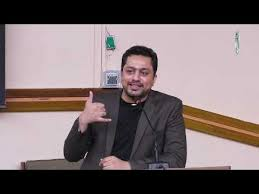

In [13]:
#save_image_from_url("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxIQEhUSEhIVFRUQFhAVFhcWFRUVFxYQFRUXFhYWFxYYHSggGBolHhcVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQGi0dHx0tLSstLSstLS0rKy0rLS0tLSstLS0rLS0tLS0tLS0tKy0tLS0tLS03Li03OCsrLSsrK//AABEIAMIBAwMBIgACEQEDEQH/xAAcAAEAAQUBAQAAAAAAAAAAAAAAAQIDBAUHBgj/xABJEAABAwEDBgoECgkFAQEAAAABAAIDEQQhMQUGEkFRkRMiUmFxgZKhsdEyU3LSBxYkM0JDVLLB8BQVFzRzgpPC4SNEYqLxo2P/xAAZAQEBAQEBAQAAAAAAAAAAAAAAAQIDBAX/xAAhEQEBAAICAQUBAQAAAAAAAAAAAQIRAxIxEyFBUWEEIv/aAAwDAQACEQMRAD8A4aiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICldIzCYP0k3D5t/i1dQhibyRuCNTHb5nRfUccTeSNwV9sLeSNwRelfKqL6u4FvJbuCkQt5LdwQ6PlBF9YcA3kt3BOAbyW7gh1fJ6L6w4FvJbuCngW8lu4IdXyci+seBbyW7gqXxNp6LcRqG0IdHygi+rZIm3cVuI1DYqImtJcC1tzjqGGr8dyHR8qovq/gW8lu4IYW8lu4IdK+UEX1dwLeS3cE4FvJbuCHR8oovq3gW8lu4JwLeS3cEOj5SRfV3BN5LdwTgm8lu4IdHyii+rTC3kt3BRwLeS3cEOj5TRfVnAt5LdwTgW8lu4IdHymi+rOBbyW7gnAt5LdwQ6PlNF9WcC3kt3BQ6Ng+i2/mCHR8qIvqvgW8lu4KDC3kt3BDo+VUX1TwLeSNwRDo5BmD+9H+G77zV1GBcvzAHyo80b/vNXUYVb5aw8MuNZDQrEavhGlSrAVKkFBUiIiUREUQVEuHW3xCrVEmHWPFFimXV7X9rl57K2XGWeWhrpCuqoLSXNobxfpAn/1egmxb7Z+49c8zni+USmtSCCG6yHG8Dnqa02V2LWLz/wBfJnx8e8PL31htYlYHjBwBGq4gHC/btWSvOZmz6UAaQQYy4EEU+kSPzzL0SldeLK54TK/IVC1+VsvWay/PzNYTg3Fx59EX0Wphz+sDruGoedrh1qOm3pkWPYbdFO3Tie17drSDfz7FkICKVCCCoVShASilEFKKpEELXWo/KIRU31FKGhJNam7UGml62NFjW2McR/0g9u6oH9yMcnhkIpIUURtCKaKEHG8wB8qP8N33mLqkIXLvg9/ej/Cf95q6lCrfLOHhlMVwKhqutUaVBS1QpagrVKqUFBAVShSiewqJMOsKuipk/EIsW5sY/b/setXbclwyvcZC7jEggPc2uOppxp3Laz4x+2fuPURx8YkbfPzQYeS8lR2duiwUqak6ycLzruAHUvP5/Z2foTOCiNJ3gEGgOhGTTSvuqaGgXsSuN5wt/SMrysdQhr4mj2WxsqN+kifkeXlgtVpJkIfIXYuxJPPrKsyWGYCronAC4nRIXb7HYWUuAbW/ACqqnyYHDUVz711nBL8uF2a1yQuDmvc28XglpFMDcu1Zj51i3NMbq8LE0Em6j24Fwpga0r0rzuceSIeDfWNtQDq1rSfBc4syg1oOMU7XbCLneLQtY5bc8sOlm3ZioVSLQpREQEREBERAVl7eODStxHRe03jWKDfRXkRLNwCgqURVKKpEHG/g9/enfwn/AHmrqUK5b8H/AO9H+G/7zV1KFW+WcPDLarrVaYrwCjSVWFFFUECiUUojKEopRAoqJNXSFWqXjDpCNLc1xZ7Xi1w/HvVJtUbSQXC49PgreUsB0nwWgtmUxZw0mMEOB41G10tIjRvGy/oaRrWscZfLOWWnpTbIzSjxf0rmULWtntloIvdPIwOcK0YKGoGw1/6r0Nmy2JzRsejQNq7ig1qLqADUHHG6it2WBmlI15FHOce9Tkkkb4P9X3aqzZzPaRouZK2oBAaWuBOokraZXzi0CGCE6bgCG6VO9XI8nQNc1ofXSdW80FRsGtY+U8lttMr2uLQaUbXX0EYG9c3q61gyW7hOLJHo6WI0g6/ZULT/AAa2F36zkNDowxzX87nMa0dYLty3LsjCAuLjVx1VNB0BZ/we2V7XzyUGjOSa/Sqw6LR0en3KY33sc+XG2Tb21EVShdHBSUoqlCCFKUSiCKKFUoIQQimiUQQimiUQQimiIOOfB8PlR/hu+81dThZzLh1ktD4ySxxaaUqCQaEjYskZZtA+uk7bvNTky6045uO6MYrzWFcJblu0evk7bvNVDLc/r5O27zXL1fx09P8AXdwxTorhX65n9c/tu81DsrzH6156Xv8ANPW/D0/13bRKaC4QcqS+sdvcqTlGT1jt5T1vw9P9d50U0VwF9uk1vcesqgWp+oneU9X8PT/X0CRzq3I4XXjHaFwM2mQ0Gk6gwFTQLZW2wcHZoLQ17iZdIPacGuvoW81AtTO34PT/AF13KczQWVIoKl1+AupvvXkcs2YTFp0iODDhcGmpLq1qXDbSlFzqWcvFHXg6v/VjGxxcgbgumGdnw454y/Lpub+T2Mkq55po6J+bFQXMvFHnk7NatZXe2N72g8YgPadukDS/pqOpc4jgY01DACL601ra2eN7YRPiS8mn/wCYoKDm4pPWnJe0a4r1vs3bLLPIaSivB00SHjAip+jUH81VqC1uszyGxvOlTSJq4UqOMHVor/6zs9oo7hXxGlBoOxdz1BFFi5WytFEykby5x1k39Kz8PReSa23Ftme+pJreAOc7F7fN+xmGFocKON7gaXG+65cTlyrKS0hxbQgtINKFpB0hz1ovQ5O+Ee2sIEgjmaMSW6Dz/Mzig/yqY4/Lnycu3XUXksl/CBZJaCTShJ5Y0m19puA6QF6izWlkjdKN7Xt2tcHDeFtz2uFAEUoCgqVCCEREBERARQUQSiiqIOA5PiaSS+oaBU0rXEAYLbxRWTWXnt+a1QlaRdG1pOsONfBXY6bV5+fP33HXh9sdNy2OwjU/fJ7yuaNgP0Hb5PxctONHlK4A3ldy8tyrv2jZgWIfQdXoJ7tK9WqWXZ/8x+L1h0btO4qaD/l2Sp3z+jtGyjmsIF8JPPojzVX6TYvs/wD1b7y1gZzP7J8lPBHU2TsO8lN5neNmbXYvs1eljPNUm32Mf7VvZjWt4B/q5D/K7yU/orz9VJ2HeSv+/pe8bvJk1lmkbG2yMq7WWx0A1k3allZ35Oe5kMUMbiGlxo1twoBTC4YlY+aVhcJDIWuboinGBFSdlehe1MoAqRVevhtk3WMv9TTktoyVKwVfE9o20u3rE0F1a0zODbqX1xAuHRrXMrZHoSObUGjnXjA36l6Mbt5eTj6+7EcKAnmKyMhZxsbEIJ7gBxX0uofou8+ZWrRcxx5j4LQmIK5YyucyuN3G3yjZ4CeEjkjNKkgObU9VVS6KCJ1ZXh1Gg0YCeMQCG1GNxx5liZPyvPZg4QzyRiS5wYaaXSsRoDzQ1q41Os7ST03rMx0vqT6boScJx9HRbQBrdjdXX5q0H0uAxWWwXCmF1OhUTNAJOvDrWmd7WQ0krJs5fGdJjnMcMHNcWkdBCmNmiL8cVS9+rWbzzN1qj32ZWd80krLNPx+EqGPuDqgE8blVpSuPSugEL5/ssh4VrmkjRIoQaHqIwXsLDnPaosJnOGyTj9543evPy8047Nu3Hjco6gi8bZM+z9bB1xu/td5rdWTOiyS/Whh2SAsv9o8U9RTHmwy8VbhY26USMhwq0gg6wajeFJC6SopUkKUV2ilQqioTYiiKUTY8xZskRj6tvZCzosnRj6tnZC2fBBTwaahvbFZYo/Vs7IV9tkj5DeyFd0VIV1BbFmZyW7gqxA3kjcFcClE2tiIbB3KeCGwblWgQ2oMY2LByvlCOztbpelIQ1jdZcSL+YCt58wtl3c645l3Lf6TbxI01a17WR8zGnEDnNT1po37ugaVRpE1JrerT7SG68ML7qrT5Syg6KMm64EjoXO5c5Z5SeNo+ysad8uSY+XVcpSz8EXQtDydQe1p6q4rwGULLapJHSvgeLqmjSQABj3YrVxZWnH1z96uNyxO6oMr6UpStLjiLtS1I5Z545LFsk4h6h3rUkrMyi/igbT4LBBPWum3nUlbLI1nvLtgp1n/CwFvclspGOe/f/hQTBxNJvJvHsn/N3WFS6g4x/JU2vEOH0MfZOPmrcjtJ4AwF6Kuk7ecnoWO4kCpHpm/o1NFMVXb5NFtOUQOpW479teipI8Goq/k94bIxzxVtRpDaDiG9C9WbJA/0ZNE7H3X9Jp4rx5r+bz5Bb6CSrQa4gLwf2TWrp6v58vMZ0mRpBeAHDa0+dBuWHJC5hvBHT+CrjkLfRJb7JI7llx5UkwcQ4f8AIX06R5Lw7xen2rEstofGase5h2scW76Lc2TPG1R3Oc2QbHtoe02nfVYRtcLvTiLa/SYaivSKeCCxRP8Am5QeZ2P4HuXSZZTxTpK9TZM+oz87C9vOwh4r3Fbux5ess1AyZlTqcdA7nUr1Lms2SpW/RrztNe7HuWHJGRcR1EUO7Fdcf6c55c8uGfDs9FBC5LYsrzw3RyvaNlai7mNQtxY89rQz0wyQc40Hb23dy74/1YfPs53isdC0UXk2Z+x0vgfXmc099yLp6+H2nTJ6sBTRVIvQ4KaJRVKFFiFKIhRKIpCI8xn/AJZ/RrMWtP8AqWjSY3mZTju3ED+YLj0Fs4KQSUBLamhwvBGrpr1BbjPXLTrVaXuwbGTGwbGtJv6TivMTO2KsWttlXOV08bY6UIaA87XUvpzLzrH0J6lepQKwahwH+Uhct1tYG6Qqsizx4nnVuzGjVmWX0eklVGtyliBsBPf/AIWHgr2UJayOGyg3D/KsE05ykRUKnDEr0cdGt5mjwWhsLKvaOeu5be0uvDegnoGA/OxFinhbuc3npKxIyWXjXt1cyzHXLDdV1+oEjruQql79N7QTtK2TWnUd4Woaf9QU1C5bQSgXGpOwCqBKKXeC6hm3kSz2mxQOfG0nQoXC51WuIN46Fy/SBwrXYbvFdX+Dd9bCwcl8w3vLv7lmzbeN1WNa8yG/VSubzOo4LTWrNa0s+i142sNDuK6TRCFwy/nwvw6zOuO2myPbc5rmH/k0jvwWOWHYCF2aSFrrnAHpvWptmbFmkqeD0SdbTonuXG/y/VdJy/bmkNqewcV7m82I3FZrMsPIpI1kg3Hy7l6K2Zj64pT0OAI3rSWzNi1R4xh42sP4FccuDknxt1nLFoTWZ+LXRnaLx3V8FUMmtffHI1/Nge7yWqlicw0c1zabRRUh2u7wXKyzzG+2NbF2Sn8nvHmixW2yQXBz+px80WfY/wAuyqURfcfPRVFNEooIRToqkyNH0hvCgkq1apNFj3DFrXu6wCfwVq0ZSgZ6c0bfae0eJWJPl2yEOabTFxgQeOMCKIOCzPrft8Viucr9sjMbiwmugSK6iBcCOY4rCe5Vzqt192KiyxVNVtMlR8CySZwIfoaMIcCDwkh0XSDZoNDqHa5uyotWWLuQ0uNFyzIHAMrsqfxUWewvkroMLtEVNATQG4E7L16KyZkzyx8d7YwR7Rp3DvS2RrHG5eHPa1JOJcSVWxlLyvV5dzHnsw0ozwzRjQaLuzrHQvKuJrTWLiNYI1EKy7Zyxs8s7JLeM5x1D8+Cy2GpLtvhqWNZRRgHLJJ6MAFfdJRCLVsloqYh/p43aR0hsJFBvv3BWZ4HnVdtV+Bv+m9pxLoj4hIixYQC555NB+K2ULgBhRYsNhp17VlCz0Fw/PNsRUvJOzpN+6i6f8F5+RmuqWTwauVadLtx28xG1dW+DBvyMnlSyHcGj8FGsXrlClFGkKURRpCEKVCosz2djxRzQ7pAK0tszSssl4ZoHawkL0BChS4yrLY8Q/4PmEmkz+5F7dFj0sfpe1VqlzqL50/aNlT7W7+nF7ig/CJlQ/7t39OL3F124dnaM78tSQxgwu0TpX3A3U5+deJOWJbQA+SR1S1laEtGA1DaaleBtmd9tmFJJy7+WMeDVhxZctDRRshA6G+SzWrnNOivId6VXe0SfEqng28kblz/AOMFp9adzfJPjDafWnst8lNJ2dDawamjcFVpLnfxitXrT2WeSj4w2n1p7LfJOp2e7tlijlpptrTXeDvCsQZIhYQ4Rio2kkdNCV4v4w2r1p7LfJPjBafWnc3yTSbj0uUn8I/mbcPz+cFjxx0XmzlWbl9zfJP1tNy+5vkt7Tb3uRLY2IivpPc1pxuZdeNpr4BdKsTBQU0iNRfcekB146gvnqPLE7SHCQgtNQaNx3LZNz2ygMLS7sx+6sWbdsObrNO6PjxBNVrZ8hWeY1kiY47SBXfiuP8Ax6yj9pd2I/dUjPrKI/3J7EXuqdW7z434eqy9kkQyuYBdcR0LXgUFCAV5i2ZzWuZ2lJMXGlK6LBd1BWP11P6z/qw/gukrz2zb1tjsznuLGuDQGl3o1uBwxV205JZGKumIqKm4C5t41ryMWX7Q30XgVFPm48Oyq35y2p2MgPTHEfFq1MpGXrsnWKORpLZn3HDinxxHQsQS6ibxUdYJC823OS1BwcJKECgoyMXVrgG0V4Z223157EfuqXKLNNqRiNfjsK7LmNZxDYYATQuaZDW75xxfgeYhcF+N1t9eeyz3VBzstvrz2We6s7alj6WNoZy27wqHWyMYyM7TfNfNnxstnrz2We6hzstvrz2We6p7r2xfSByjD61naCpOVYB9Y3v8l84fGu2evPZZ7qHOu2evPZZ5J7r3xfRjcswFzWCS95DRxXXuPUtgvmSPOy2Nc1wnNWEOB0IzRwwIq1Z/7Rsqfa3f04vcVS5z4fRZUL51/aNlT7W7+nF7iftGyp9rd/Ti9xDu+ikXzr+0XKn2t39OL3EQ7vKoiI5iIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiIP/Z","q2.jpg")

In [11]:
# Example usage
image_path = "./images/Fatima1.jpg"
q2 = create_image_embedding(image_path)

# 'embedding' now contains a dense vector representation of the image
print("Image Embedding Shape:", q2.shape)
print("Image Embedding:", q2)

Image Embedding Shape: (512,)
Image Embedding: [ 2.33396906e-02 -1.97558827e-03 -6.59882426e-02  9.94308367e-02
  5.68067841e-02  4.13036346e-02 -5.57346791e-02  2.69905236e-02
 -4.22182418e-02  1.57304108e-02  2.73002721e-02  3.22358459e-02
 -4.28939350e-02  1.69546418e-02  5.86699806e-02 -6.57564178e-02
  3.31830606e-02  9.67113599e-02  3.53259481e-02 -4.83786725e-02
 -6.13883622e-02  3.06106396e-02  5.56395054e-02 -3.70847210e-02
 -6.77524460e-03 -2.92252959e-03  4.13161777e-02 -1.20267747e-02
  5.41126467e-02  3.21275182e-03 -1.95411108e-02 -2.11430825e-02
 -1.63891837e-02  5.82626574e-02 -2.45407559e-02 -3.99103239e-02
 -3.89122367e-02 -2.36135651e-03 -7.19788447e-02  6.47758469e-02
 -3.45490538e-02 -1.23079028e-02 -1.99142601e-02 -7.92307127e-03
  3.09956800e-02 -1.09178002e-03 -3.23415454e-03  1.36373313e-02
 -1.10326968e-01 -7.49271177e-03  3.21916454e-02 -9.25628841e-03
  7.47417510e-02  2.53559207e-03 -6.72270432e-02 -3.63197215e-02
 -5.06171957e-02  4.68680188e-02 -1.2004399

In [12]:
image_path = "./images/Mama1.jpg"
cat2 = create_image_embedding(image_path)

# 'embedding' now contains a dense vector representation of the image
print("Image Embedding Shape:", cat2.shape)
print("Image Embedding:", cat2)

Image Embedding Shape: (512,)
Image Embedding: [ 5.85408621e-02 -1.09868438e-03 -6.75724670e-02  6.39401898e-02
 -1.23365233e-02  4.21871319e-02 -2.46587098e-02  5.60998060e-02
 -2.02880315e-02 -1.01089403e-01 -1.36232739e-02  2.04500295e-02
  9.75819118e-03 -4.77575790e-03  4.42324765e-02  2.36301478e-02
  5.47326952e-02  1.63078692e-03 -1.66244972e-02 -9.91698205e-02
 -6.03894331e-02  4.28633904e-03  2.85973195e-02  1.33260700e-03
  2.25316007e-02  1.88566167e-02  2.38239914e-02 -5.37987463e-02
  7.30174687e-03  2.94888057e-02 -6.01074286e-02  3.75106744e-03
 -2.47812606e-02  2.79388595e-02 -1.17200382e-01  9.14315656e-02
  9.81638441e-05  3.32520530e-02 -7.58338720e-02  6.83301454e-03
  1.85503103e-02 -2.41057053e-02 -1.77563087e-03 -4.76593040e-02
  3.50169465e-02  2.67957593e-03  3.48376147e-02  6.79845661e-02
 -1.06163666e-01  2.36568754e-04  6.10018559e-02  3.44888791e-02
  3.01967151e-02 -1.66789144e-02 -1.02531135e-01  1.86084248e-02
 -8.40464793e-03  9.76172835e-03  4.4642880

In [14]:
fatima1 = create_image_embedding("./images/Fatima1.jpg")
fatima2 = create_image_embedding("./images/Fatima2.jpg")
baba1 = create_image_embedding("./images/Baba1.jpg")
baba2 = create_image_embedding("./images/Baba2.jpg")
mama1 = create_image_embedding("./images/Mama1.jpg")


In [15]:
!pip install -Uq milvus-lite

!pip install -Uq pymilvus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.5 MB/s eta 0:00:00


In [16]:
from pymilvus import MilvusClient
client = MilvusClient("./milvus_demo.db")

In [17]:
from pymilvus import MilvusClient
import numpy as np

client = MilvusClient("./milvus_demo.db")
client.create_collection(
    collection_name="images",
    dimension=512)  # The vectors we will use in this demo has 384 dimensions

In [18]:
data = [{"id": 1, "person_name": "Fatima Khan", "vector": fatima1},
    {"id": 2, "person_name": "Fatima Khan", "vector": fatima2},
    {"id": 3, "person_name": "Abdul Faheem", "vector": baba1},
    {"id": 4, "person_name": "Abdul Faheem", "vector": baba2},
    {"id": 5, "person_name": "Gul-E-Nargis", "vector": mama1}]

In [19]:
res = client.insert(
    collection_name="images",
    data=data)

In [20]:
res = client.search(
    collection_name="images",
    data=[fatima2],
    limit=1,
    output_fields=["id", "person_name"],
)
print(res)

data: ["[{'id': 2, 'distance': 1.0, 'entity': {'person_name': 'Fatima Khan', 'id': 2}}]"] 


In [21]:
res = client.search(
    collection_name="images",
    data=[mama1],
    limit=1,
    output_fields=["id", "person_name"],
)
print(res)

data: ["[{'id': 5, 'distance': 0.9999998807907104, 'entity': {'person_name': 'Gul-E-Nargis', 'id': 5}}]"] 
